# SECTION 1️⃣ — Problem framing

**Business Goal:**  
Reduce customer churn by accurately identifying customers at risk of leaving, enabling targeted retention strategies.

**Constraints:**

- **Latency:** Predictions must be available within operational timelines (e.g., daily batch or near real-time).
- **Cost:** Solution should balance predictive performance with infrastructure and maintenance costs.
- **Explainability:** Models must provide interpretable outputs to support business decisions and regulatory requirements.

**Offline Metric vs Online Metric:**

- **Offline:** Evaluate model performance using metrics such as accuracy, precision, recall, F1-score, and AUC on historical data.
- **Online:** Monitor real-world impact through retention rates, incremental revenue, and customer engagement post-deployment.

**Failure Tolerance:**  
Define acceptable thresholds for false positives/negatives and establish fallback mechanisms to minimize business risk in case of model or data issues.


# SECTION 2️⃣ — Imports + Data + Understanding Of Data

In [1]:
!pip install -q pandas numpy matplotlib scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)

### Read Data


In [3]:
df = pd.read_csv("./data/raw_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Understanding the Data Before Building a Non-ML Baseline

Before constructing any baseline (ML or non-ML), it is critical to first understand the data and its generating process. 

The goal of this step is not prediction, but sense-making—to ensure that any baseline logic is grounded in both domain semantics and observable evidence.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


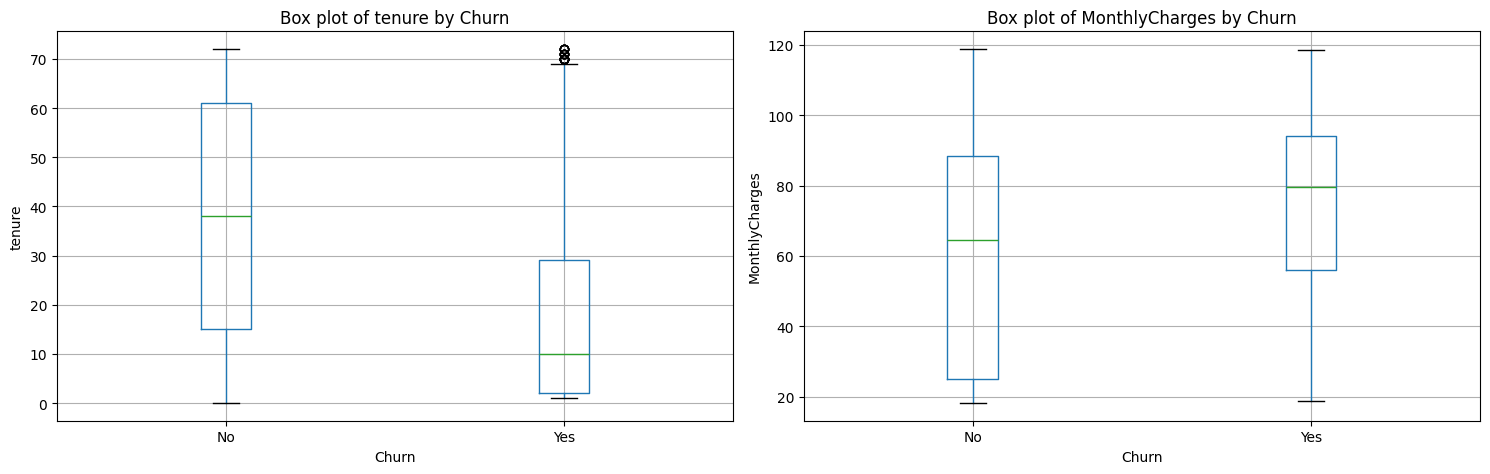

In [5]:
# box plot numeric columns value vs Churn
numeric_columns = ["tenure", "MonthlyCharges"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, col in enumerate(numeric_columns):
    df.boxplot(column=col, by="Churn", ax=axes[i])
    axes[i].set_title(f"Box plot of {col} by Churn")
    axes[i].set_xlabel("Churn")
    axes[i].set_ylabel(col)
plt.suptitle("")
plt.tight_layout()
plt.show()

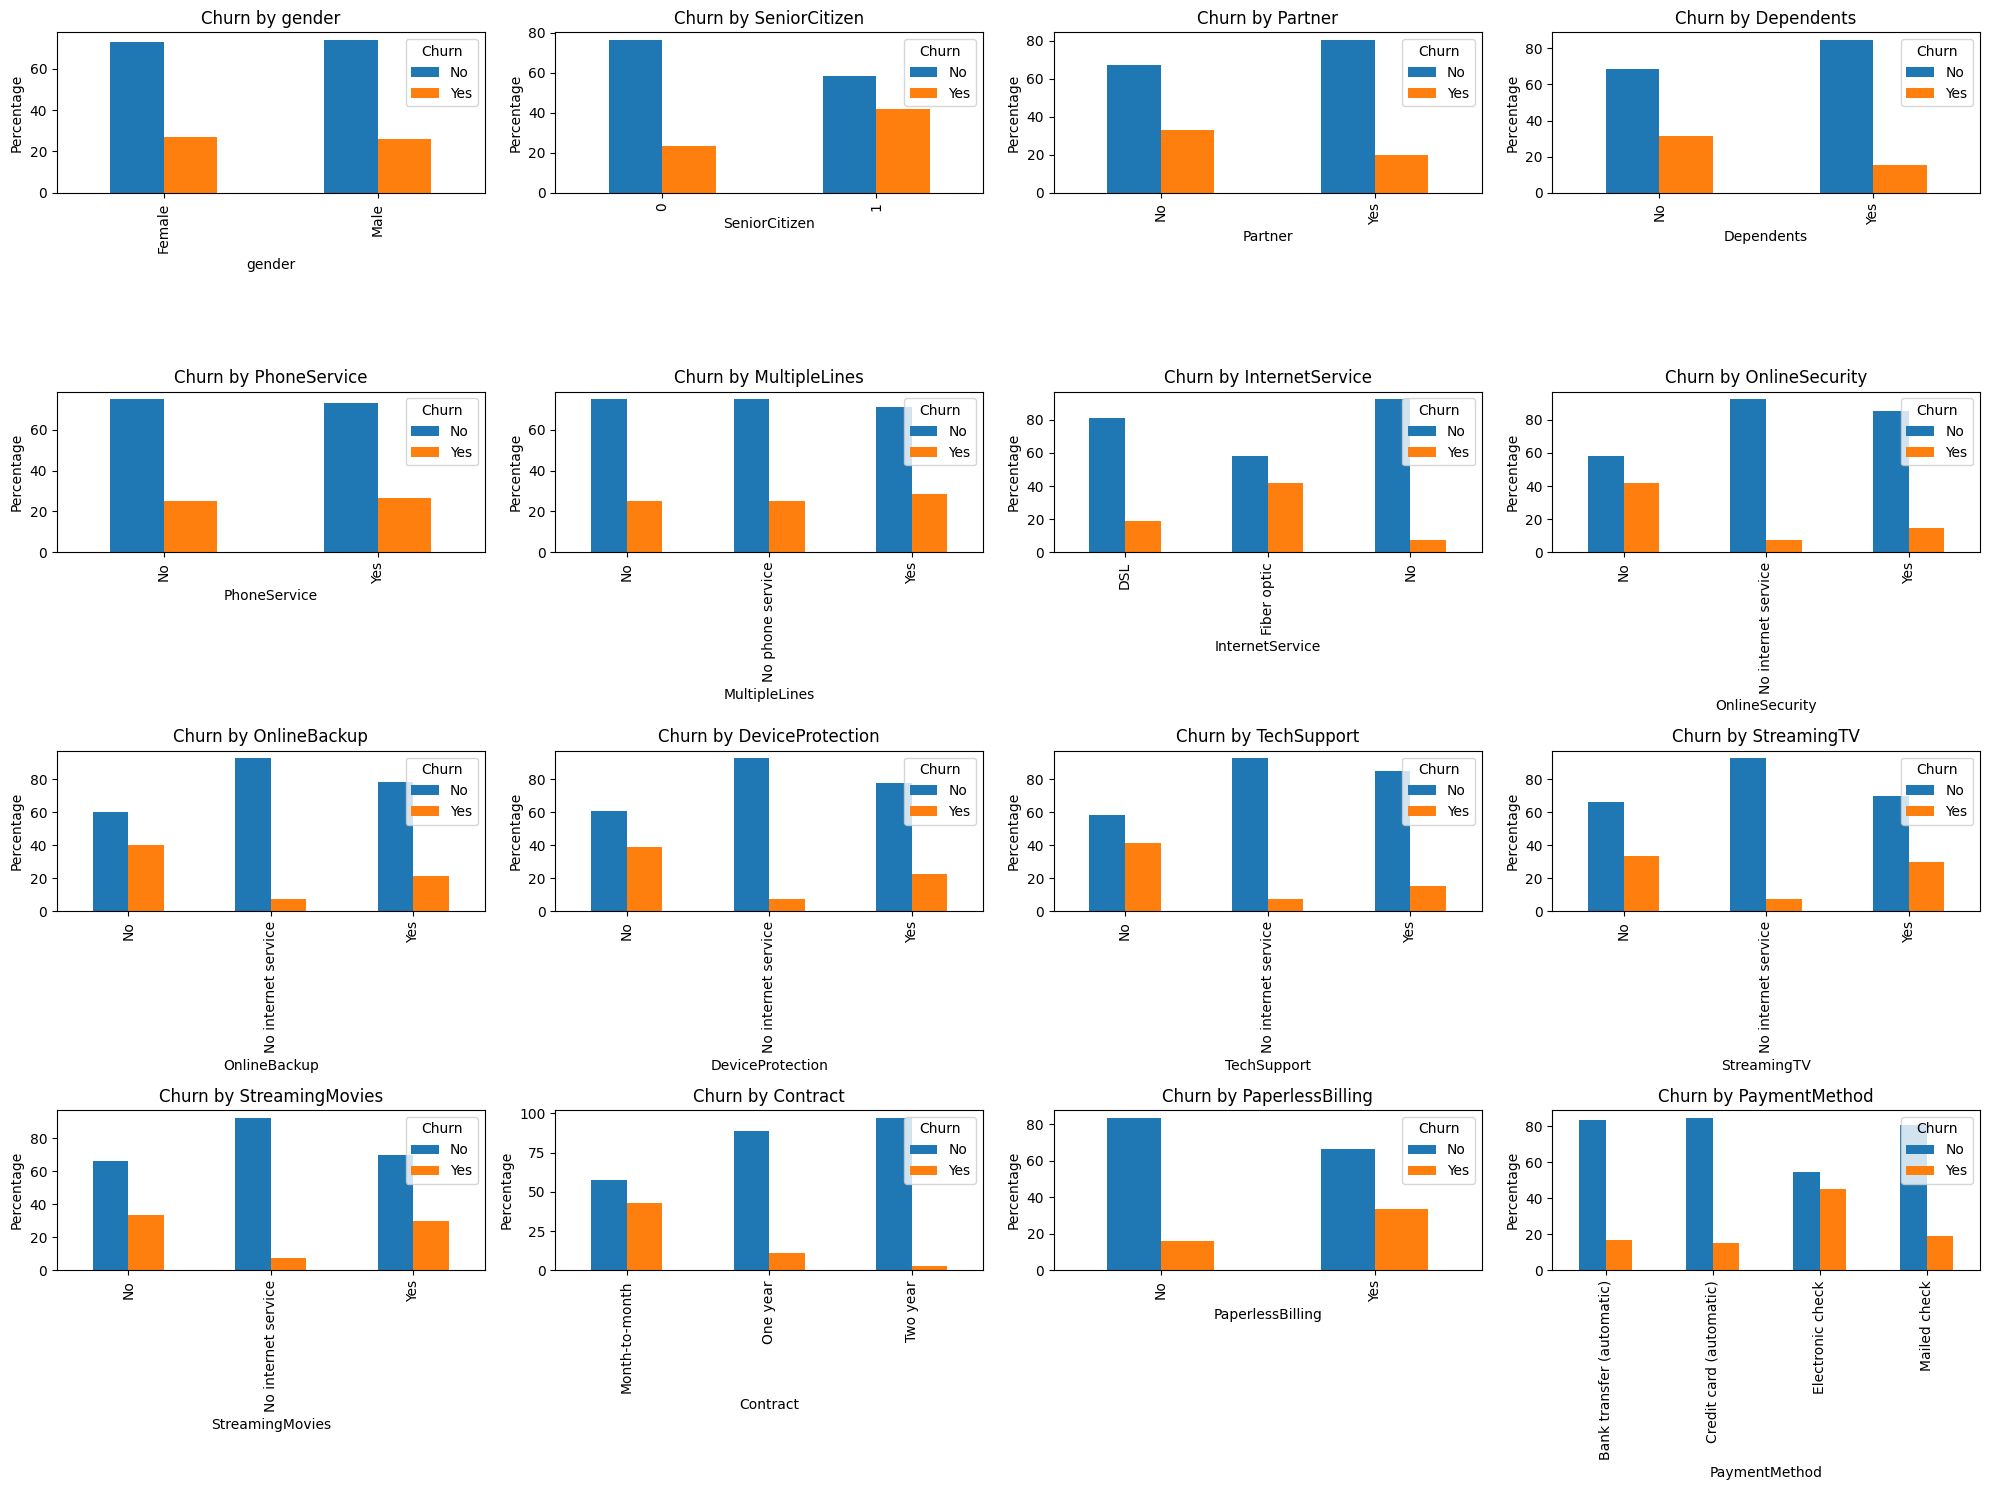

In [6]:
# box plot categorical data vs Churn
categorical_columns = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]


fig, axes = plt.subplots(4, 4, figsize=(20, 15))

for i, col in enumerate(categorical_columns):
    ct = pd.crosstab(df[col], df["Churn"], normalize="index") * 100
    ax = axes[i // 4, i % 4]
    ct.plot(kind="bar", ax=ax)
    ax.set_title(f"Churn by {col}")
    ax.set_ylabel("Percentage")
    ax.legend(title="Churn", loc="upper right")
plt.tight_layout()
plt.show()

# SECTION 3️⃣ — Non-ML Base Line


Label: Churn = Yes/No
If customer renew then Churn = No
If customer does not renew then Churn = Yes

From the columns, the high signal columns (guess by name/description or asked the data collection team) are

- tenure (signal: high, <= 10)
- MonthLyCharges (signal: low, >= 80)
- Contract (signal: high, 'Month-to-month')
- PaymentMethod (signal: low, 'Electronic check')
- OnlineSecurity (signal: low, 'No')
- TechSupport (signal: low, 'No')

Hence a Base Could for Churn could be
(I will use a scoring base on how strong is the signal based on the data)

```
Score = 0
+2 if tenure <= 10
+2 if Contract == Month-to-month
+1 if MonthlyCharges >= 80
+1 if PaymentMethod == Electronic check
+1 if OnlineSecurity == No
+1 if TechSupport == No

Churn = Yes if Score >= 4 Else No
```

I expect this to give me high precision and moderate recall (confident, not exhaustive) performance


In [7]:
def rule_based_churn(df):
    score = np.zeros(len(df))

    score += (df["tenure"] <= 10) * 2
    score += (df["Contract"] == "Month-to-month") * 2
    score += (df["MonthlyCharges"] >= 80) * 1
    score += (df["PaymentMethod"] == "Electronic check") * 1
    score += (df["OnlineSecurity"] == "No") * 1
    score += (df["TechSupport"] == "No") * 1

    return (score >= 4).astype(int)

In [8]:
# testing the rule-based churn function
rule_based_churn(df.copy())

0       1
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    1
7041    1
7042    0
Name: tenure, Length: 7043, dtype: int64

# SECTION 4️⃣ — Prepare Data


In [9]:
df_cleaned = df.copy()

Drop unless columns


In [10]:
df_cleaned = df_cleaned.drop(columns=["customerID"])

Check for Null Values and If needed Drop Column


In [11]:
df_cleaned.isna().sum()

# df_cleaned.dropna(subset=['column_with_too_many_nulls'], inplace=True)

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The biggest leakage risk in this dataset

TotalCharges

Why?

- TotalCharges ≈ MonthlyCharges × tenure
- It already encodes tenure
- It accumulates after the customer starts service
- For churned customers, it implicitly contains how long they stayed


In [12]:
df_cleaned = df_cleaned.drop(columns=["TotalCharges"])

# SECTION 5️⃣ — Separate out Test and Train Data

In [13]:
df_cleaned["Churn"] = df_cleaned["Churn"].map({"Yes": 1, "No": 0}).astype("int8")
train_set, test_set = train_test_split(
    df_cleaned, test_size=0.2, stratify=df_cleaned["Churn"], random_state=42
)

# SECTION 6️⃣ — Feature Engineering (manual + domain-aware)


Target and Features Separation

In [14]:
X = train_set.drop('Churn', axis=1)
y = train_set['Churn']

Identify feature types

In [15]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "category"]).columns

 Custom engineered features

In [16]:
X = X.copy()

# Tenure buckets
X["TenureGroup"] = pd.cut(
    X["tenure"],
    bins=[0, 12, 24, 48, 100],
    labels=["0-1yr", "1-2yr", "2-4yr", "4yr+"]
)
cat_features = list(cat_features) + ["TenureGroup"]

# High value customer flag
X["HighValueCustomer"] = (X["MonthlyCharges"] > X["MonthlyCharges"].median()).astype(int)

Preprocessing pipeline

In [17]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# SECTION 7️⃣ — MODEL Building

Hold-out test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

ML pipeline

In [19]:
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

Baseline evaluation (Stratified CV)

In [20]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=skf,
    scoring="roc_auc"
)

print("Baseline CV ROC-AUC:", cv_scores.mean())

Baseline CV ROC-AUC: 0.8440756822683528


Hyperparameter tuning

In [21]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

/Users/siddhartha/Projects/ai/telco_churn_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/siddhartha/Projects/ai/telco_churn_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/siddhartha/Projects/ai/telco_churn_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' i

Best Params: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV ROC-AUC: 0.844617409739015


/Users/siddhartha/Projects/ai/telco_churn_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/siddhartha/Projects/ai/telco_churn_detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Single Test Evaluation


In [22]:
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))

Test ROC-AUC: 0.8490984440889924


Threshold optimization

In [23]:
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for t in thresholds:
    preds = (y_test_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

Best Threshold: 0.6000000000000002


Perfomance report

In [24]:
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       828
           1       0.59      0.72      0.65       299

    accuracy                           0.79      1127
   macro avg       0.74      0.77      0.75      1127
weighted avg       0.81      0.79      0.80      1127



# SECTION 8️⃣ — Feature importance


In [25]:
feature_names = (
    best_model.named_steps["preprocess"]
    .get_feature_names_out()
)

coefficients = best_model.named_steps["model"].coef_[0]

feature_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefficients
    })
    .sort_values(by="coef", key=abs, ascending=False)
)

feature_importance.head(20)

,feature,coef
37,cat__Contract_Two year,-0.787351
1,num__tenure,-0.739100
35,cat__Contract_Month-to-month,0.729835
2,num__MonthlyCharges,0.683543
10,cat__PhoneService_Yes,-0.583183
45,cat__TenureGroup_1-2yr,-0.379785
19,cat__OnlineSecurity_Yes,-0.299750
42,cat__PaymentMethod_Electronic check,0.274515
46,cat__TenureGroup_2-4yr,-0.267209
38,cat__PaperlessBilling_No,-0.238127


# Final Model Selection

    •	Performance vs cost
    •	Stability
    •	Explainability


# Model Packaging

    •	Model artifacts
    •	Feature code
    •	Environment (conda / docker)
    •	Versioning


# Deployment Architecture

    •	Batch vs real-time
    •	Model serving path
    •	Feature availability
    •	Latency budget


# Monitoring Strategy

## Data Drift Monitoring

    •	Input feature distribution shift
    •	PSI / KS / Wasserstein
    •	Reference window

## Prediction Drift

    •	Output distribution shift
    •	Confidence collapse

## Concept Drift

    •	Performance decay
    •	Delayed labels
    •	Retraining triggers

## Signal Loss Detection

    •	Feature missing rate spikes
    •	Zero / constant features
    •	Cardinality collapse
    •	Late-arriving data


# Alerts & Thresholds

    •	Warning vs critical
    •	Who gets paged
    •	Auto-disable model logic


# Fallback Strategy

    •	Switch to non-ML baseline
    •	Last known good model
    •	Partial feature mode


# Retraining & Automation Strategy

    •	Scheduled vs trigger-based
    •	Drift-based retraining
    •	Human-in-the-loop


# Model Governance

    •	Model registry
    •	Audit trail
    •	Approval workflow


# Post-Deployment Validation

    •	Shadow mode
    •	Canary deployment
    •	A/B testing


# Failure Modes & Risk Register

    •	Data outages
    •	Upstream schema changes
    •	Adversarial inputs
    •	Model staleness


# Conclusions & Next Steps

    •	Remaining risks
    •	Scalability plan
    •	Future improvements


## Remaining Risks

    •	Delayed or noisy labels limit fast performance validation
    •	Subtle concept drift not detected by simple drift metrics
    •	Partial upstream signal degradation or schema changes
    •	Monitoring and alerting latency before rollback

## Scalability Plan

    •	Scale data processing via partitioned or distributed pipelines
    •	Autoscale model serving and separate batch vs real-time inference
    •	Sample-based monitoring and segmented metrics
    •	Support multiple model versions via registry and CI/CD

## Future Improvements

    •	Add stronger predictive signals and freshness tracking
    •	Improve uncertainty estimation and calibration
    •	Automate drift-triggered retraining and fallback
    •	Use online evaluation (A/B tests, shadow deployment)
